<a href="https://colab.research.google.com/github/uwtintres/robotic_surgeries/blob/main/Promethee_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used for the PROMETHEE II algorithm with custom weights. The processing is done according to the next steps:

1. Load .xlsx file with columns as attributes and rows as alternatives.
2. Provide the array of weights as an input to the processing function. Also, the criteria types should be provided as the array, where the NB value should be used in the weights of attributes with cost criteria (minimum value of the attribute is preferred), while for the attribute with benefit criteria (max value is preferred) B value should be provided.
3. Processing of the input file is done on this step according to the weights provided on step 2.
4. Visualizing the results.

The following code is used for the PROMETHEE experiment with custom weights. Each step of the experiment is printed for better understanding and the visualization chart for the rankings is provided afterwards.

In [48]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

class Promethee():
    evaluation_matrix = np.array([])  # Matrix
    normalized_decision = np.array([])  # Normalisation matrix
    preference_matrix = np.array([])
    M = 0  # Number of rows
    N = 0  # Number of columns

    '''
	Create an evaluation matrix consisting of m alternatives and n criteria.
	  '''

    def __init__(self, evaluation_matrix, weight_matrix, criteria):
        # M×N matrix
        self.evaluation_matrix = np.array(evaluation_matrix, dtype="float")

        # M alternatives (options)
        self.row_size = len(self.evaluation_matrix)

        # N attributes/criteria
        self.column_size = len(self.evaluation_matrix[0])

        # N size weight matrix
        self.weight_matrix = np.array(weight_matrix, dtype="float")
        self.weight_matrix = self.weight_matrix/sum(self.weight_matrix)
        self.criteria = np.array(criteria, dtype="float")

    '''
	# Step 2
	The matrix  is then normalised.
	'''

    def step_2(self):
        # normalized scores
        self.normalized_decision = np.copy(self.evaluation_matrix)
        for i in range(self.row_size):
            for j in range(self.column_size):
              minval = min(self.evaluation_matrix[:, j])
              maxval = max(self.evaluation_matrix[:, j])
              if self.criteria[j]:
                self.normalized_decision[i,j] = (self.evaluation_matrix[i, j] - \
                                                   minval) / (maxval - minval)
              else:
                self.normalized_decision[i,j] = (maxval - self.evaluation_matrix[i, j]) /\
                                                  (maxval - minval)
    '''
	# Step 3
	Calculate the preference matrix 
	'''

    def step_3(self):
        # for each alternative in the input matrix
        for i in range(self.row_size):
          preference_array = []
          # comparing it to each other alternative in the matrix
          for row in range(self.row_size):
            difference = []
            for col in range(self.column_size):
              diff = self.normalized_decision[i, col] - self.normalized_decision[row,col]
              val = diff if diff >= 0 else 0
              difference.append(val * self.weight_matrix[col]) # multiplying the difference by the weight of current attribute
            # after checking with one of the alternatives, append the sum of differences to preference function
            preference_array.append(sum(difference)/sum(self.weight_matrix))
          #print("preference array", preference_array)
          # collecting all preference functions to a preference matrix for further calculations
          if len(self.preference_matrix) == 0:
            self.preference_matrix = [preference_array]
          else:
            self.preference_matrix = np.vstack((self.preference_matrix, preference_array))
        #print("preference matrix", self.preference_matrix)
    '''
	# Step 4
	Determine the leaving and entering outranking flows
	'''

    def step_4(self):
        self.positive_flow = np.zeros(self.row_size)
        self.negative_flow = np.zeros(self.row_size)
        self.outranking_flow = np.zeros(self.row_size)

        for i in range(self.row_size):
          self.positive_flow[i] = sum(self.preference_matrix[i,:]) / (self.row_size - 1)

        for j in range(self.column_size):
          self.negative_flow[j] = sum(self.preference_matrix[:,j]) / (self.row_size - 1)
        
        for i in range(self.row_size):
          self.outranking_flow[i] = self.positive_flow[i] - self.negative_flow[i]                                        
 
    def ranking(self, data):
        return [i+1 for i in np.argsort(-1*data)]

    def rank_to_preformance_score(self):
        return self.ranking(self.outranking_flow)

    def visualization(self, ranking):
        #ax = fig.add_axes([0,0,1,1])
        axes = []
        for i, rank in enumerate(ranking):
          axes.append(((rank), (i + 1)))
        axes.sort(key=lambda x: x[0])
        x_axis,y_axis = ['A' + str(val[0]) for val in axes],[val[1] for val in axes]
        plt.figure(figsize=(12, 6))
        ax = pd.Series(y_axis).plot(kind='bar')
        ax.set_xticklabels(x_axis)

        rects = ax.patches
        for rect, label in zip(rects, y_axis):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
        ax.bar(x_axis,y_axis)

    def calc(self):
        print("Step 1\n", self.evaluation_matrix, end="\n\n")
        self.step_2()
        print("Step 2\n", self.normalized_decision, end="\n\n")
        self.step_3()
        print("Step 3\n", self.preference_matrix, end="\n\n")
        self.step_4()
        print("Step 4\n", self.outranking_flow, end="\n\n")
       

The driver code for testing is presented below. The execution plan is as follows:

1. Read the excel file, where the file name and sheet_name should be provided to specify which case user wants to test.
2. Read the excel file to store the weights and criteria values.
3. Create Promethee instance with the read values
4. Calculate the rankings

In [49]:
import numpy as np
import pandas as pd 

xl = pd.read_excel("TOPSIS with custom weights.xlsx", sheet_name="Beginning")
xl = pd.read_excel("TOPSIS with custom weights.xlsx", sheet_name="Beginning", 
                   usecols=range(1, len(xl.columns)+1))

# initializing input matrix, weights, criterias
input_matrix = xl.tail(n=len(xl.index) - 2).values.tolist()
weights = xl.loc[0].values
criterias = xl.head(n=0).columns.values
new_criterias = []
for criteria in criterias:
  # if the attribute is non beneficiary, meaning min value is better -> False, 
  # otherwise, the criteria is True
  new_criterias.append(False if criteria[0] == 'N' else True)
print('input matrix: ', input_matrix)
print('weights: ', weights)
print('criterias: ', new_criterias)
# creating Topsis instance with the values above

input matrix:  [[21, 300, 90, 60], [45, 800, 74, 30], [64, 700, 12, 90], [86, 1000, 36, 10], [75, 100, 24, 5], [34, 1200, 47, 23], [56, 400, 55, 67], [90, 350, 67, 84], [60, 580, 74, 75], [70, 460, 86, 98], [80, 220, 98, 46], [10, 900, 40, 15]]
weights:  [0.6 0.1 0.1 0.2]
criterias:  [False, False, False, False]


Step 1
 [[  21.  300.   90.   60.]
 [  45.  800.   74.   30.]
 [  64.  700.   12.   90.]
 [  86. 1000.   36.   10.]
 [  75.  100.   24.    5.]
 [  34. 1200.   47.   23.]
 [  56.  400.   55.   67.]
 [  90.  350.   67.   84.]
 [  60.  580.   74.   75.]
 [  70.  460.   86.   98.]
 [  80.  220.   98.   46.]
 [  10.  900.   40.   15.]]

Step 2
 [[0.8625     0.81818182 0.09302326 0.40860215]
 [0.5625     0.36363636 0.27906977 0.7311828 ]
 [0.325      0.45454545 1.         0.08602151]
 [0.05       0.18181818 0.72093023 0.94623656]
 [0.1875     1.         0.86046512 1.        ]
 [0.7        0.         0.59302326 0.80645161]
 [0.425      0.72727273 0.5        0.33333333]
 [0.         0.77272727 0.36046512 0.15053763]
 [0.375      0.56363636 0.27906977 0.24731183]
 [0.25       0.67272727 0.13953488 0.        ]
 [0.125      0.89090909 0.         0.55913978]
 [1.         0.27272727 0.6744186  0.89247312]]

Step 3
 [[0.         0.22545455 0.42337977 0.55113636 0.405      0.17931818
  0.28664467 0.5

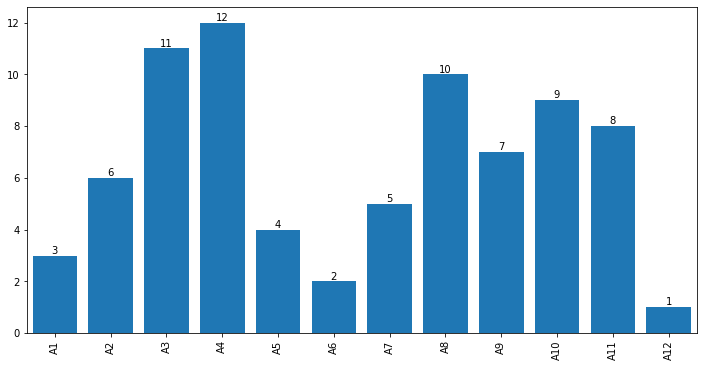

In [50]:
t = Promethee(input_matrix, weights, new_criterias)

# calculating the ranking
t.calc()

ranks = t.rank_to_preformance_score()

print("Visualization graph:")
t.visualization(ranks)  